# Use

Click (SHIFT+Enter) on the line below for installing pomegranade. This will also install a new version of numpy.
Then click on the button: "Restart runtime" 
After the restart, skip the line with `pip install` and execute the cells below.



In [ ]:
!pip install pomegranate

     |████████████████████████████████| 17.9MB 224kB/s 
     |████████████████████████████████| 15.3MB 323kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [ ]:
import pomegranate as pg
from collections import namedtuple
import sys
from graphviz import Digraph
import matplotlib.pyplot as plt

In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Proposed model

In [ ]:
def plot_node(node, graph):
  special_options = {}
  if node.is_observable:
    special_options['fillcolor']='#e9f2de'
    special_options['style']='filled'
    special_options['shape']='box'
  if "map" in node.label.lower():
    special_options['penwidth']='2'
    special_options['fillcolor']='#e5e5e5'
    special_options['style']='filled'
  graph.node(node.label, **special_options)

Node = namedtuple('Node',['is_observable','label','children'])


lane_marking_match = Node(is_observable=True, label= 'Lane marking match', children= [])
landmark_match = Node(is_observable=True, label='Landmark match', children=[])

localization = Node(is_observable=False, label='Localization', children=[landmark_match, lane_marking_match])

landmark_accuracy = Node(is_observable=False, label='Landmark accuracy', children=[landmark_match, localization])
lane_marking_accuracy = Node(is_observable=False, label='Lane marking accuracy', children=[lane_marking_match, localization])



camera = Node(is_observable=False, label='Camera', 
              children=[lane_marking_accuracy, landmark_accuracy
                        ])
radar = Node(is_observable=False, label='Radar', 
              children=[landmark_accuracy])
                        
lidar = Node(is_observable=False, label='LiDAR', 
              children=[landmark_accuracy])

weather = Node(is_observable=True, label='Weather', 
              children=[camera, radar, lidar])

map = Node(is_observable=False, label='Map validity', 
              children=[lane_marking_match, landmark_match, localization])

all_nodes = (lane_marking_match, landmark_match, 
             landmark_accuracy, localization,
             lane_marking_accuracy, camera, radar, lidar, weather, map)

## Plot version 1 with map validation on top

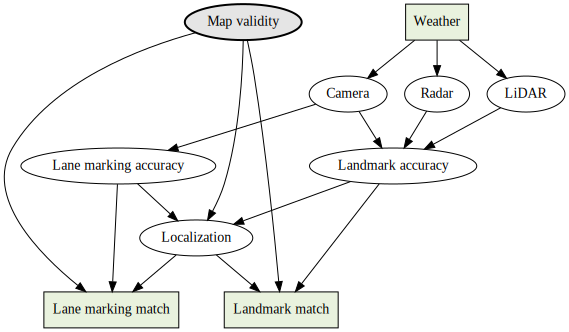

In [ ]:
top_nodes = (weather, map)

s = Digraph('subgraph')
s.graph_attr.update(rank='min')
for node in top_nodes:
  plot_node(node, s)
  
g = Digraph('G')
for node in all_nodes:
  plot_node(node, g)
  for child in node.children:
    g.edge(node.label, child.label)

g.subgraph(s)

g

## Plot version 2 with map validation in the center

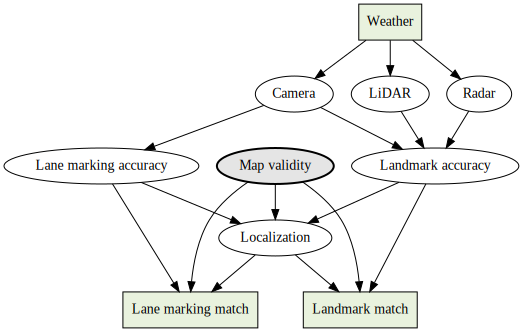

In [ ]:
top_nodes = ()

s = Digraph('subgraph')
s.graph_attr.update(rank='min')
for node in top_nodes:
  plot_node(node, s)
  
g = Digraph('G')
for node in all_nodes:
  plot_node(node, g)
  for child in node.children:
    g.edge(node.label, child.label)

g.subgraph(s)

g

In [ ]:
MapLabels = namedtuple('MapLabels', ['valid', 'invalid'])
map_labels = MapLabels('Valid', 'Invalid') 

WeatherLabel = namedtuple('WeatherLabel',['cooperative','non_cooperative'])
weather_label = WeatherLabel(cooperative="cooperative", non_cooperative="non_cooperative")

SensorStatusLabel = namedtuple('SensorStatus', ['nominal', 'degraded'])
sensor_status_label =  SensorStatusLabel(nominal="Nominal", degraded="Degraded")
radar_status_label = sensor_status_label
camera_status_label = sensor_status_label
lidar_status_label = sensor_status_label

AccuracyLabel = namedtuple('AccuracyLabel', ['high','low'])
accuracy_label = AccuracyLabel(high="High", low="Low")

lane_marking_accuracy_label = accuracy_label
landmark_accuracy_label = accuracy_label
localization_label = accuracy_label

MatchLabel = namedtuple('MatchLabel',['detected','not_detected'])
match_label = MatchLabel(detected="Detected", not_detected="Not detected")

lane_marking_match_label = match_label
landmark_match_label = match_label


In [ ]:
def verify_sum_of_probability_is_one(discrete_variable) -> bool:
    parameters = discrete_variable.parameters
    sum_of_probability = sum(parameters[0].values())
    return abs(sum_of_probability - 1.0) <= sys.float_info.epsilon

## A priori distributions

In [ ]:
map_distribution = pg.DiscreteDistribution({map_labels.valid: 0.8, map_labels.invalid: 0.2})
weather_distribution = pg.DiscreteDistribution({weather_label.cooperative: 0.5, weather_label.non_cooperative: 0.5})

In [ ]:
are_all_valid = all([verify_sum_of_probability_is_one(x) for x in (map_distribution, weather_distribution)])
if are_all_valid: 
  printmd("**All distributions are correctly parametrized**")
else:
  raise RuntimeError("One of the variables is not correctly parametrized!")

**All distributions are correctly parametrized**

## Dependent distributions

In [ ]:
def get_conditional_distributions(in_dictionary=None):
  def get_distribution_to_use(distribution_name):
    if in_dictionary and (distribution_name in in_dictionary):
      return in_dictionary[distribution_name]
    else:
      return default_distributions[distribution_name]

  def select_distribution(name, default_distribution):
    if in_dictionary and (name in in_dictionary):
      return in_dictionary[name]
    else:
      return default_distribution

  default_distributions = {"map_distribution": map_distribution,
                           "weather_distribution": weather_distribution}
                           
  default_distributions["camera_status_distribution"] = pg.ConditionalProbabilityTable(
        [
        [weather_label.cooperative, camera_status_label.nominal, 0.9],
        [weather_label.cooperative, camera_status_label.degraded, 0.1],

        [weather_label.non_cooperative, camera_status_label.nominal, 0.3],
        [weather_label.non_cooperative, camera_status_label.degraded, 0.7],
        
        ], [get_distribution_to_use("weather_distribution")])

  
  default_distributions["radar_status_distribution"] = pg.ConditionalProbabilityTable(
        [
        [weather_label.cooperative, radar_status_label.nominal, 0.99],
        [weather_label.cooperative, radar_status_label.degraded, 0.01],

        [weather_label.non_cooperative, radar_status_label.nominal, 0.7],
        [weather_label.non_cooperative, radar_status_label.degraded, 0.3],
        
        ], [get_distribution_to_use("weather_distribution")])

  default_distributions["lidar_status_distribution"] = pg.ConditionalProbabilityTable(
      [
      [weather_label.cooperative, lidar_status_label.nominal, 0.8],
      [weather_label.cooperative, lidar_status_label.degraded, 0.2],

      [weather_label.non_cooperative, lidar_status_label.nominal, 0.2],
      [weather_label.non_cooperative, lidar_status_label.degraded, 0.8],
      
      ], [get_distribution_to_use("weather_distribution")])
  

  
  default_distributions["lane_marking_accuracy_distribution"] = pg.ConditionalProbabilityTable(
    [
     [camera_status_label.nominal, accuracy_label.high, 0.85],
     [camera_status_label.nominal, accuracy_label.low, 0.15],

     [camera_status_label.degraded, accuracy_label.high, 0.3],
     [camera_status_label.degraded, accuracy_label.low, 0.7],
     
    ], [get_distribution_to_use("camera_status_distribution")])


  default_distributions["landmark_accuracy_distribution"] = pg.ConditionalProbabilityTable(
    [
     [camera_status_label.nominal, radar_status_label.nominal, lidar_status_label.nominal, accuracy_label.high, 0.95],
     [camera_status_label.nominal, radar_status_label.nominal, lidar_status_label.nominal, accuracy_label.low, 0.05],
     [camera_status_label.nominal, radar_status_label.nominal, lidar_status_label.degraded, accuracy_label.high, 0.7],
     [camera_status_label.nominal, radar_status_label.nominal, lidar_status_label.degraded, accuracy_label.low, 0.3],
     
     [camera_status_label.nominal, radar_status_label.degraded, lidar_status_label.nominal, accuracy_label.high, 0.8],
     [camera_status_label.nominal, radar_status_label.degraded, lidar_status_label.nominal, accuracy_label.low, 0.2],
     [camera_status_label.nominal, radar_status_label.degraded, lidar_status_label.degraded, accuracy_label.high, 0.5],
     [camera_status_label.nominal, radar_status_label.degraded, lidar_status_label.degraded, accuracy_label.low, 0.5],


     [camera_status_label.degraded, radar_status_label.nominal, lidar_status_label.nominal, accuracy_label.high, 0.8],
     [camera_status_label.degraded, radar_status_label.nominal, lidar_status_label.nominal, accuracy_label.low, 0.2],
     [camera_status_label.degraded, radar_status_label.nominal, lidar_status_label.degraded, accuracy_label.high, 0.4],
     [camera_status_label.degraded, radar_status_label.nominal, lidar_status_label.degraded, accuracy_label.low, 0.6],
     
     [camera_status_label.degraded, radar_status_label.degraded, lidar_status_label.nominal, accuracy_label.high, 0.4],
     [camera_status_label.degraded, radar_status_label.degraded, lidar_status_label.nominal, accuracy_label.low, 0.6],
     [camera_status_label.degraded, radar_status_label.degraded, lidar_status_label.degraded, accuracy_label.high, 0.01],
     [camera_status_label.degraded, radar_status_label.degraded, lidar_status_label.degraded, accuracy_label.low, 0.99],
     
    ], [get_distribution_to_use("camera_status_distribution"), 
        get_distribution_to_use("radar_status_distribution"), 
        get_distribution_to_use("lidar_status_distribution")])



  default_distributions["localization_distribution"] = pg.ConditionalProbabilityTable(
    [
     [lane_marking_accuracy_label.high, map_labels.valid, landmark_accuracy_label.high, localization_label.high, 0.95],
     [lane_marking_accuracy_label.high, map_labels.valid, landmark_accuracy_label.high, localization_label.low, 0.05],
     [lane_marking_accuracy_label.high, map_labels.valid, landmark_accuracy_label.low, localization_label.high, 0.7],
     [lane_marking_accuracy_label.high, map_labels.valid, landmark_accuracy_label.low, localization_label.low, 0.3],

     [lane_marking_accuracy_label.high, map_labels.invalid, landmark_accuracy_label.high, localization_label.high, 0.1],
     [lane_marking_accuracy_label.high, map_labels.invalid, landmark_accuracy_label.high, localization_label.low, 0.9],
     [lane_marking_accuracy_label.high, map_labels.invalid, landmark_accuracy_label.low, localization_label.high, 0.1],
     [lane_marking_accuracy_label.high, map_labels.invalid, landmark_accuracy_label.low, localization_label.low, 0.9],


     [lane_marking_accuracy_label.low, map_labels.valid, landmark_accuracy_label.high, localization_label.high, 0.8],
     [lane_marking_accuracy_label.low, map_labels.valid, landmark_accuracy_label.high, localization_label.low, 0.2],
     [lane_marking_accuracy_label.low, map_labels.valid, landmark_accuracy_label.low, localization_label.high, 0.2],
     [lane_marking_accuracy_label.low, map_labels.valid, landmark_accuracy_label.low, localization_label.low, 0.8],

     [lane_marking_accuracy_label.low, map_labels.invalid, landmark_accuracy_label.high, localization_label.high, 0.1],
     [lane_marking_accuracy_label.low, map_labels.invalid, landmark_accuracy_label.high, localization_label.low, 0.9],
     [lane_marking_accuracy_label.low, map_labels.invalid, landmark_accuracy_label.low, localization_label.high, 0.1],
     [lane_marking_accuracy_label.low, map_labels.invalid, landmark_accuracy_label.low, localization_label.low, 0.9],
    
     
    ], [get_distribution_to_use("lane_marking_accuracy_distribution"), 
        get_distribution_to_use("map_distribution"), 
        get_distribution_to_use("landmark_accuracy_distribution")])


  lane_marking_match_conditional_distribution_table = [
     [lane_marking_accuracy_label.high, map_labels.valid, localization_label.high, match_label.detected, 0.99],
     [lane_marking_accuracy_label.high, map_labels.valid, localization_label.high, match_label.not_detected, 0.01],
     [lane_marking_accuracy_label.high, map_labels.valid, localization_label.low, match_label.detected, 0.6],
     [lane_marking_accuracy_label.high, map_labels.valid, localization_label.low, match_label.not_detected, 0.4],

     [lane_marking_accuracy_label.high, map_labels.invalid,  localization_label.high, match_label.detected, 0.1],
     [lane_marking_accuracy_label.high, map_labels.invalid,  localization_label.high, match_label.not_detected, 0.9],
     [lane_marking_accuracy_label.high, map_labels.invalid,  localization_label.low, match_label.detected, 0.1],
     [lane_marking_accuracy_label.high, map_labels.invalid,  localization_label.low, match_label.not_detected, 0.9],



     [lane_marking_accuracy_label.low, map_labels.valid,  localization_label.high, match_label.detected, 0.7],
     [lane_marking_accuracy_label.low, map_labels.valid,  localization_label.high, match_label.not_detected, 0.3],
     [lane_marking_accuracy_label.low, map_labels.valid,  localization_label.low, match_label.detected, 0.4],
     [lane_marking_accuracy_label.low, map_labels.valid,  localization_label.low, match_label.not_detected, 0.6],

     [lane_marking_accuracy_label.low, map_labels.invalid,  localization_label.high, match_label.detected, 0.1],
     [lane_marking_accuracy_label.low, map_labels.invalid,  localization_label.high, match_label.not_detected, 0.9],
     [lane_marking_accuracy_label.low, map_labels.invalid,  localization_label.low, match_label.detected, 0.1],
     [lane_marking_accuracy_label.low, map_labels.invalid,  localization_label.low, match_label.not_detected, 0.9],

  ]


  default_distributions["lane_marking_match_distribution"] = pg.ConditionalProbabilityTable(
    lane_marking_match_conditional_distribution_table
    , [get_distribution_to_use("lane_marking_accuracy_distribution"), 
       get_distribution_to_use("map_distribution"), 
       get_distribution_to_use("localization_distribution")])

  default_distributions["landmark_match_distribution"] = pg.ConditionalProbabilityTable(
      lane_marking_match_conditional_distribution_table,
      [get_distribution_to_use("landmark_accuracy_distribution"), 
       get_distribution_to_use("map_distribution"), 
       get_distribution_to_use("localization_distribution")]
      )

  out_distribution = {}
  key_values = ("camera_status_distribution", 
                "radar_status_distribution",
                "lidar_status_distribution",
                
                "lane_marking_accuracy_distribution",
                "landmark_accuracy_distribution",
                
                "localization_distribution",
                
                "lane_marking_match_distribution",
                "landmark_match_distribution")
  
  for i_key in key_values:
    out_distribution[i_key] = select_distribution(i_key, default_distributions[i_key])
  return out_distribution

In [ ]:
default_conditional_distributions = get_conditional_distributions()

In [ ]:
# write global variables
for key in default_conditional_distributions:
  globals()[key] = default_conditional_distributions[key]

# Create the network

In [ ]:
def get_admissible_node_name(in_label):
  return in_label.replace(" ", "_")

In [ ]:
def get_pgm(in_dictionary=None):
  def get_distribution_to_use(distribution_name):
    if in_dictionary and (distribution_name in in_dictionary):
      return in_dictionary[distribution_name]
    else:
      return globals()[distribution_name]


  weatherPgNode = pg.Node(get_distribution_to_use("weather_distribution"), name=weather.label)
  cameraPgNode = pg.Node(get_distribution_to_use("camera_status_distribution"), name=camera.label)
  radarPgNode = pg.Node(get_distribution_to_use("radar_status_distribution"), name=radar.label)
  lidarPgNode = pg.Node(get_distribution_to_use("lidar_status_distribution"), name=lidar.label)

  mapPgNode = pg.Node(get_distribution_to_use("map_distribution"), name=map.label)
  laneMarkingAccuracyPgNode = pg.Node(get_distribution_to_use("lane_marking_accuracy_distribution"), name=lane_marking_accuracy.label)
  landMarkAccuracyPgNode = pg.Node(get_distribution_to_use("landmark_accuracy_distribution"), name=landmark_accuracy.label)

  localizationPgNode = pg.Node(get_distribution_to_use("localization_distribution"), name=localization.label)

  laneMarkingMatchPgNode = pg.Node(get_distribution_to_use("lane_marking_match_distribution"), name=lane_marking_match.label)
  landmarkMatchPgNode = pg.Node(get_distribution_to_use("landmark_match_distribution"), name=landmark_match.label)


  model = pg.BayesianNetwork("Map validity problem")

  pg_model_nodes = (
      weatherPgNode, cameraPgNode, radarPgNode, lidarPgNode, mapPgNode, 
                  laneMarkingAccuracyPgNode, landMarkAccuracyPgNode,
                  localizationPgNode,
                  laneMarkingMatchPgNode, landmarkMatchPgNode
  )

  model.add_states(*pg_model_nodes)

  model.add_edge(weatherPgNode, cameraPgNode)
  model.add_edge(weatherPgNode, radarPgNode)
  model.add_edge(weatherPgNode, lidarPgNode)
  model.add_edge(cameraPgNode, laneMarkingAccuracyPgNode)
  model.add_edge(cameraPgNode, landMarkAccuracyPgNode)

  model.add_edge(radarPgNode, landMarkAccuracyPgNode)
  model.add_edge(lidarPgNode, landMarkAccuracyPgNode)

  model.add_edge(landMarkAccuracyPgNode, localizationPgNode)
  model.add_edge(mapPgNode, localizationPgNode)
  model.add_edge(laneMarkingAccuracyPgNode, localizationPgNode)

  model.add_edge(laneMarkingAccuracyPgNode, laneMarkingMatchPgNode)
  model.add_edge(mapPgNode, laneMarkingMatchPgNode)
  model.add_edge(localizationPgNode, laneMarkingMatchPgNode)

  model.add_edge(landMarkAccuracyPgNode, landmarkMatchPgNode)
  model.add_edge(mapPgNode, landmarkMatchPgNode)
  model.add_edge(localizationPgNode, landmarkMatchPgNode)


  model.bake()
  return [model, pg_model_nodes]

In [ ]:
model, pg_model_nodes = get_pgm()
#list(default_conditional_distributions.keys())


In [ ]:
Sample = namedtuple('Sample',
                    ['weather', 'map_validity', 'radar', 'camera', 'lidar',
                     'lane_marking_accuracy', 'landmark_accuracy',
                     'localization',
                     'lane_marking_match', 'landmark_match',
                     'probability', 'log_probability'])

HiddenVariable = namedtuple('HiddenVariable',
                             ['map_validity', 'radar', 'camera', 'lidar', 
                              'lane_marking_accuracy', 'landmark_accuracy',
                              'localization',
                              'probability', 'log_probability'])

In [ ]:
def compute_probability_of_samples(model, weather_symbol, 
                                   lane_marking_match_symbol, 
                                   landmark_match_symbol):
  
  out = []
  for camera_symbol in camera_status_label:
    for radar_symbol in radar_status_label:
      for lidar_symbol in lidar_status_label:
        for map_symbol in map_labels:
          for lanemarking_accuracy_symbol in lane_marking_accuracy_label:
            for landmark_accuracy_symbol in landmark_accuracy_label:
              for localization_symbol in localization_label:
                symbols = [weather_symbol, camera_symbol, radar_symbol, lidar_symbol,
                           map_symbol, lanemarking_accuracy_symbol, 
                           landmark_accuracy_symbol, 
                           localization_symbol,
                           lane_marking_match_symbol, landmark_match_symbol]

                probability = model.probability([symbols])
                log_probability = model.log_probability([symbols])
          
                new_sample = Sample(weather=weather_symbol, 
                                    map_validity=map_symbol,
                                    radar=radar_symbol,
                                    camera=camera_symbol, 
                                    lidar=lidar_symbol,
                                    lane_marking_accuracy=lanemarking_accuracy_symbol, 
                                    landmark_accuracy=landmark_accuracy_symbol,
                                    localization=localization_symbol,
                                    lane_marking_match=lane_marking_match_symbol,
                                    landmark_match=landmark_match_symbol,
                                    probability=probability,
                                    log_probability=log_probability)
                out.append(new_sample)
  return out

In [ ]:
def compute_a_posteriori_from_symbols(model, symbols):
  a_posteriori = model.predict_proba(symbols)

  assert(len(a_posteriori) == len(pg_model_nodes))

  out_data = {}
  out_data["conditional"] = symbols
  out_data["posterior"] = []
  for posteriori, node in zip(a_posteriori, pg_model_nodes):
    current_node = {}
    try:
      current_node["distribution"] = posteriori.parameters[0]
      current_node["name"] = node.name
      out_data["posterior"].append(current_node)
    except Exception as e:
      continue
  return out_data


def compute_a_posteriori(model, weather_symbol, lane_marking_match_symbol, 
                         landmark_match_symbol):
  symbols = {
      weather.label: weather_symbol,
      lane_marking_match.label: lane_marking_match_symbol,
      landmark_match.label: landmark_match_symbol
  }

  return compute_a_posteriori_from_symbols(model, symbols)
    

In [ ]:
def GetHiddenVariable(in_sample: Sample) -> HiddenVariable:
  out = HiddenVariable(
    map_validity = in_sample.map_validity,
    radar = in_sample.radar,
    camera = in_sample.camera,
    lidar=in_sample.lidar,
    lane_marking_accuracy = in_sample.lane_marking_accuracy,
    landmark_accuracy = in_sample.landmark_accuracy,
    localization = in_sample.localization,
    probability = in_sample.probability,
    log_probability = in_sample.log_probability)

  return out

In [ ]:
def compress_label(in_label, string_length=2):
  return in_label[:string_length]

def get_digit_of_sensor_status(sensor_status):
  return 1 if sensor_status == sensor_status_label.nominal else 0

def get_x_coordinate(sample: Sample):
  camera_value = get_digit_of_sensor_status(sample.camera)
  radar_value = get_digit_of_sensor_status(sample.radar)
  lidar_value = get_digit_of_sensor_status(sample.lidar)
  value = camera_value + radar_value * 2 + lidar_value * 4
  return value


def get_label_of_coordinate(x_value):
  import math
  if (x_value< 0) or (x_value>8):
    raise RuntimeError("Unacceptable x value")

  camera_value = x_value % 2
  radar_value = math.floor(x_value / 2) % 2
  lidar_value = math.floor(x_value / 4) % 2

  coordinate_label = ""
  if camera_value > 0:
    coordinate_label += "C"
  if radar_value > 0:
    coordinate_label += "R"
  if lidar_value > 0:
    coordinate_label += "L"
  if not coordinate_label:
    return "None"
  return coordinate_label

def get_all_x_coordinates():
  return range(8)


def get_all_x_label_coordinates():
  x_values = get_all_x_coordinates()
  return [get_label_of_coordinate(x) for x in x_values]



def beautify_axes(ax):
  ax.set_axis_on()
  ax.grid(b=True, axis='y')
  ax.set_facecolor('#f5f5f5')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

def change_x_ticks(ax):
  
  ax.set_xticks(get_all_x_coordinates())
  ax.set_xticklabels(get_all_x_label_coordinates())
  

def plot_subsamples(ax, subsample, **kwargs):
  def brake_sub_sample():
    return [single_hidden_variable for single_hidden_variable in subsample 
                  if (single_hidden_variable.lane_marking_accuracy==lane_marking_accuracy_value) and 
                  (single_hidden_variable.landmark_accuracy==landmark_accuracy_value)]
  
  def get_scatter_options(lane_marking_accuracy, landmark_accuracy):
    options = {}
    if lane_marking_accuracy == lane_marking_accuracy_label.low:
      options["marker"] = "^"
      options["s"] = 100   
    if lane_marking_accuracy == lane_marking_accuracy_label.high:
      options["marker"] = "s"
      options["s"] = 130

    if landmark_accuracy == landmark_accuracy_label.low:
      options["c"] = "#1b9e77"
    if landmark_accuracy == landmark_accuracy_label.high:
      options["c"] = "#d95f02"
    return options

  legend_text=[]
  for lane_marking_accuracy_value in lane_marking_accuracy_label:
    for landmark_accuracy_value in landmark_accuracy_label:
      x = [get_x_coordinate(single_hidden_variable)for single_hidden_variable in brake_sub_sample()]
      y = [single_hidden_variable.log_probability for single_hidden_variable in brake_sub_sample()]
      scatter_options = get_scatter_options(lane_marking_accuracy_value, landmark_accuracy_value)
      ax.scatter(x, y, **scatter_options,**kwargs)
      legend_text.append("LA: {}, LM: {}".format(compress_label(lane_marking_accuracy_value),
                                                 compress_label(landmark_accuracy_value)))

  title = "Map: {}, Localization: {}".format(subsample[0].map_validity, subsample[0].localization)
  ax.set_title(title)
  ax.legend(legend_text, fontsize=16)
  beautify_axes(ax)
  change_x_ticks(ax)

In [ ]:
def get_subsamples(in_sample):
  out_data=[]
  for map_status in map_labels:
    for localization_status in localization_label:
      new_subsample = [sample_data for sample_data in in_sample if (sample_data.map_validity==map_status) and (sample_data.localization==localization_status)]
      out_data.append(new_subsample)
  return out_data

In [ ]:
def make_plot(in_sample: Sample) -> None:
  fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, frameon=False, figsize=(20,15))
  subsample = get_subsamples(in_sample)


  counter = 0
  for row_idx in range(len(axs)):
    for col_idx in range(len(axs[0])):
      plot_subsamples(axs[row_idx][col_idx], subsample[counter], alpha=0.7)
      counter += 1

In [ ]:
def get_y_values(node_names, posterior_distributions, symbol_label):
  y_values = [None for node in node_names]
  for i_posterior in posterior_distributions:
    if i_posterior["name"] in node_names:
      index = node_names.index(i_posterior["name"])
      y_values[index] = i_posterior["distribution"][symbol_label]

  return y_values

def make_low_level_plot(ax, x, posterior_distribution, labels):
  for i_label in labels:
    y = get_y_values(x, posterior_distribution, i_label)
    ax.scatter(x, y, label=i_label, s=100)

def plot_sensor_status(ax, posterior_distribution):
  x = [camera.label, radar.label, lidar.label]
  make_low_level_plot(ax, x, posterior_distribution, sensor_status_label)  

def plot_accuracy_status(ax, posterior_distribution):
  x = [localization.label, landmark_accuracy.label, lane_marking_accuracy.label]
  make_low_level_plot(ax, x, posterior_distribution, accuracy_label)  

def plot_posterior(posterior_distributions):
  fig, axs = plt.subplots(1, 2, frameon=False, figsize=(15,4))
  plot_sensor_status(axs[0], posterior_distributions)
  plot_accuracy_status(axs[1], posterior_distributions)
  for ax in axs:
    ax.legend(fontsize=16)
    ax.set_ylim([0, 1])
    beautify_axes(ax)
    
def print_probability_of_map_validity(posterior_distributions):
  map_node_index = 3
  printmd("**Map posteriori distribution: {}**".format(posterior_distributions[map_node_index]["distribution"]))


def make_analysis(model, weather_symbol, lane_marking_match_symbol, landmark_match_symbol):
  title = weather.label + ": " + weather_symbol + ", " + lane_marking_match.label +  ": " + lane_marking_match_symbol + ", " + landmark_match.label + ": " + landmark_match_symbol
  print("")
  printmd("### {}".format(title))
  temp_data = compute_a_posteriori(model, weather_symbol, 
                                           lane_marking_match_symbol=lane_marking_match_symbol,
                                           landmark_match_symbol=landmark_match_symbol)
  plot_posterior(temp_data["posterior"])
  plt.show()
  print_probability_of_map_validity(temp_data["posterior"])

# Simulation results - posterior distributions

The plot below show the probability distribution of the unknown nodes given the meaurements we have. 

In the paper here we also add the formal definition of what the posteriors below are, e.g., P(A|....) 

### Weather: cooperative, Lane marking match: Detected, Landmark match: Detected

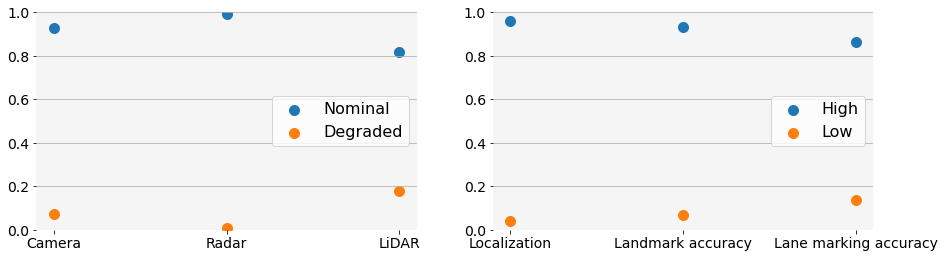

**Map posteriori distribution: {'Valid': 0.9986729301917788, 'Invalid': 0.0013270698082211653}**

### Weather: cooperative, Lane marking match: Detected, Landmark match: Not detected

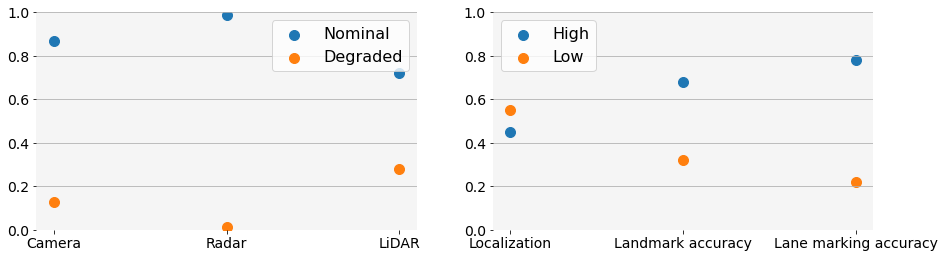

**Map posteriori distribution: {'Valid': 0.67470326215659, 'Invalid': 0.32529673784341007}**

### Weather: cooperative, Lane marking match: Not detected, Landmark match: Detected

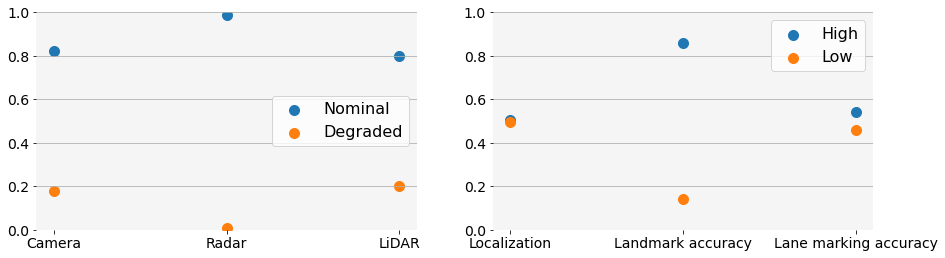

**Map posteriori distribution: {'Valid': 0.7212106475074577, 'Invalid': 0.27878935249254244}**

### Weather: cooperative, Lane marking match: Not detected, Landmark match: Not detected

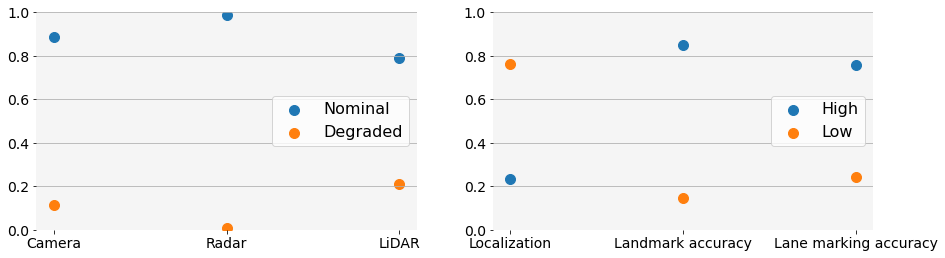

**Map posteriori distribution: {'Valid': 0.24632741633368335, 'Invalid': 0.7536725836663167}**

### Weather: non_cooperative, Lane marking match: Detected, Landmark match: Detected

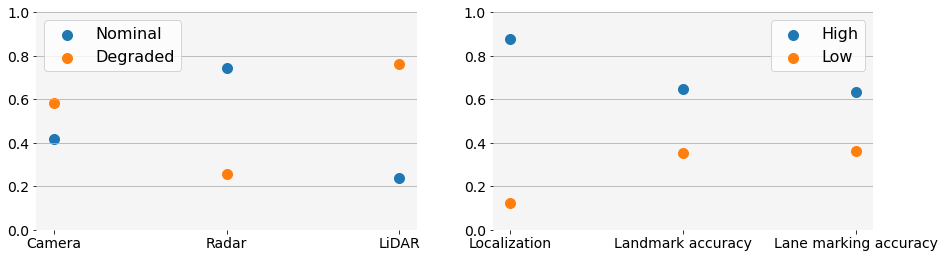

**Map posteriori distribution: {'Valid': 0.99797698911331, 'Invalid': 0.002023010886690018}**

### Weather: non_cooperative, Lane marking match: Detected, Landmark match: Not detected

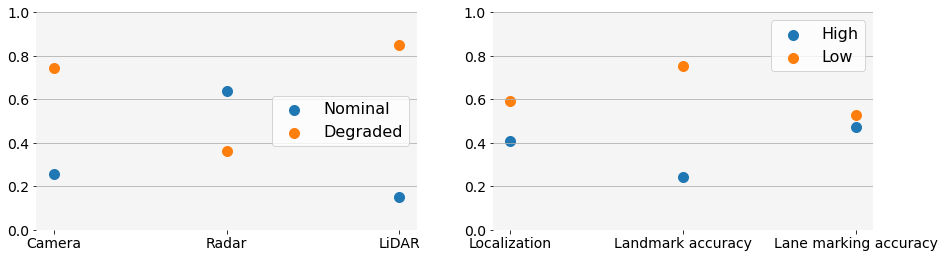

**Map posteriori distribution: {'Valid': 0.8641299800220644, 'Invalid': 0.13587001997793569}**

### Weather: non_cooperative, Lane marking match: Not detected, Landmark match: Detected

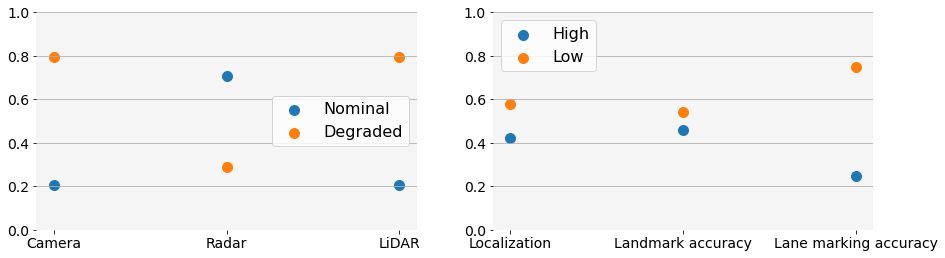

**Map posteriori distribution: {'Valid': 0.8594379489486574, 'Invalid': 0.14056205105134262}**

### Weather: non_cooperative, Lane marking match: Not detected, Landmark match: Not detected

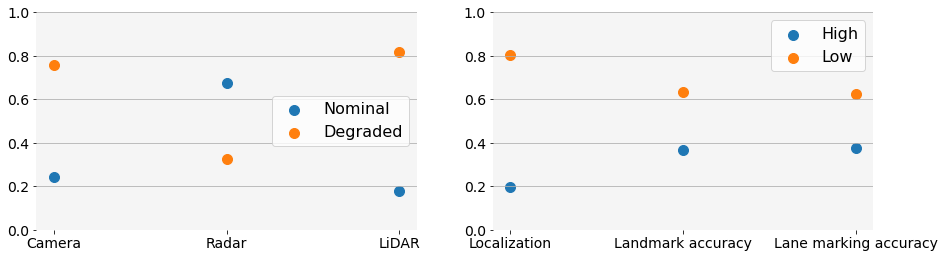

**Map posteriori distribution: {'Valid': 0.40333289237614506, 'Invalid': 0.5966671076238549}**

In [ ]:
for weather_symbol in weather_label:
  for lane_marking_symbol in lane_marking_match_label:
    for landmark_match_symbol in landmark_match_label:
      make_analysis(model, weather_symbol, lane_marking_symbol, landmark_match_symbol)

In [ ]:
temp_data = compute_a_posteriori(model, weather_label.cooperative, 
                                           match_label.detected,
                                           match_label.detected)

In [ ]:
temp_data['posterior'][0]["distribution"]



{'Degraded': 0.07353307584292779, 'Nominal': 0.9264669241570722}

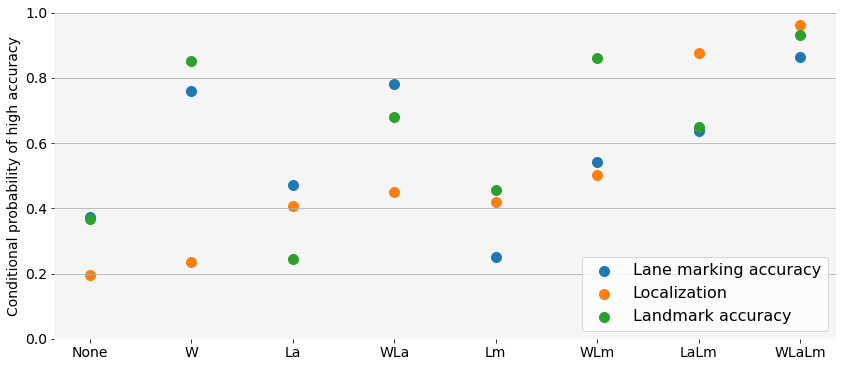

In [ ]:
def get_digit_of_measurement(measurement_label):
  if (measurement_label == weather_label.cooperative) or (measurement_label == match_label.detected):
    return 1
  else:
    return 0
  
def get_x_coordinate(weather_label, lane_marking_match_label, landmark_match_label):
  weather_value = get_digit_of_measurement(weather_label)
  lane_marking_value = get_digit_of_measurement(lane_marking_match_label)
  landmark_value = get_digit_of_measurement(landmark_match_label)
  value = weather_value + lane_marking_value * 2 + landmark_value * 4
  return value


def get_label_of_coordinate(x_value):
  import math
  if (x_value< 0) or (x_value>8):
    raise RuntimeError("Unacceptable x value")

  weather_value = x_value % 2
  lane_marking_value = math.floor(x_value / 2) % 2
  landmark_value = math.floor(x_value / 4) % 2

  coordinate_label = ""
  if weather_value > 0:
    coordinate_label += "W"
  if lane_marking_value > 0:
    coordinate_label += "La"
  if landmark_value > 0:
    coordinate_label += "Lm"
  if not coordinate_label:
    return "None"
  return coordinate_label


def get_all_x_label_coordinates_for_posterior_plots():
  x_values = list(range(8))
  return [get_label_of_coordinate(x) for x in x_values]

def change_x_ticks_posterior_plots(ax):
  ax.set_xticks(list(range(8)))
  ax.set_xticklabels(get_all_x_label_coordinates())

x = []
y_dictionary = {lane_marking_accuracy.label: [], 
     localization.label: [],
     landmark_accuracy.label: []}

for weather_symbol in weather_label:
  for lane_marking_symbol in lane_marking_match_label:
    for landmark_match_symbol in landmark_match_label:
      out_data = compute_a_posteriori(model, weather_symbol, lane_marking_symbol, landmark_match_symbol)
      x.append(get_x_coordinate(weather_symbol, lane_marking_symbol, landmark_match_symbol))
      for i_posterior in out_data["posterior"]:
        if i_posterior["name"] in y_dictionary:
          y_dictionary[i_posterior["name"]].append(i_posterior["distribution"][accuracy_label.high])

fig, ax = plt.subplots(1, 1, frameon=False, figsize=(14,6))
for i_data in y_dictionary:
  compressed_label = i_data
  #if i_data == lane_marking_accuracy.label:
    #compress_label = "Lm"
  #elif i_data == localization.label:
    #compress_label = "Loc"
  #else:
    #compress_label = "Lm"

  label = compress_label# + "_Hi"
  ax.scatter(x, y_dictionary[i_data], label=i_data, s=100)

ax.legend(fontsize=16)
ax.set_ylim([0, 1])
ax.set_ylabel("Conditional probability of high accuracy")
beautify_axes(ax)
change_x_ticks_posterior_plots(ax)


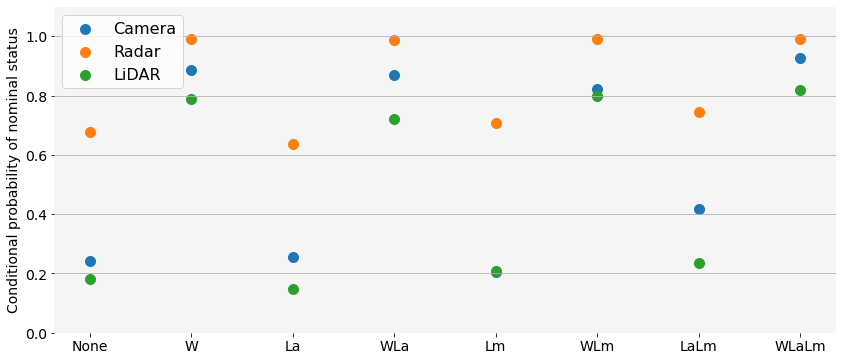

In [ ]:
x = []
y_dictionary = {camera.label: [], 
     radar.label: [],
     lidar.label: []}

for weather_symbol in weather_label:
  for lane_marking_symbol in lane_marking_match_label:
    for landmark_match_symbol in landmark_match_label:
      out_data = compute_a_posteriori(model, weather_symbol, lane_marking_symbol, landmark_match_symbol)
      x.append(get_x_coordinate(weather_symbol, lane_marking_symbol, landmark_match_symbol))
      for i_posterior in out_data["posterior"]:
        if i_posterior["name"] in y_dictionary:
          y_dictionary[i_posterior["name"]].append(i_posterior["distribution"][sensor_status_label.nominal])

fig, ax = plt.subplots(1, 1, frameon=False, figsize=(14,6))
for i_data in y_dictionary:
  compressed_label = i_data
  #if i_data == lane_marking_accuracy.label:
    #compress_label = "Lm"
  #elif i_data == localization.label:
    #compress_label = "Loc"
  #else:
    #compress_label = "Lm"

  label = compress_label# + "_Hi"
  ax.scatter(x, y_dictionary[i_data], label=i_data, s=100)

ax.legend(fontsize=16)
ax.set_ylim([0, 1.1])
ax.set_ylabel("Conditional probability of nominal status")
beautify_axes(ax)
change_x_ticks_posterior_plots(ax)

# Not relevant anymore - discard sesssion 
## Simulation results  -- probability of each sample 

The plots below show the *log-probability* of the different combination of node status under the case of map valid and localization accuracy high, map invalid localization accuracy low, etc..


**The plots below show the probability of each samples, not the a posteriori of each variable given some measurements.**

The x axis shows the combination of sensor status of camera, lidar, and radar. For example: RL means that radar and lidar are in the nominal status and camera is in the degraded status.
If all sensors are in the degraded state, then we write "None". The label of the x-axis are visible on the lower plots only.

For every x value we have 4 probability values: high lane marking accuracy and high landmark, high lane marking accuracy and low landmakr accuracy, etc...
In the legend 
- LA: Lane marking
- LM: landmark

#### Nominal case

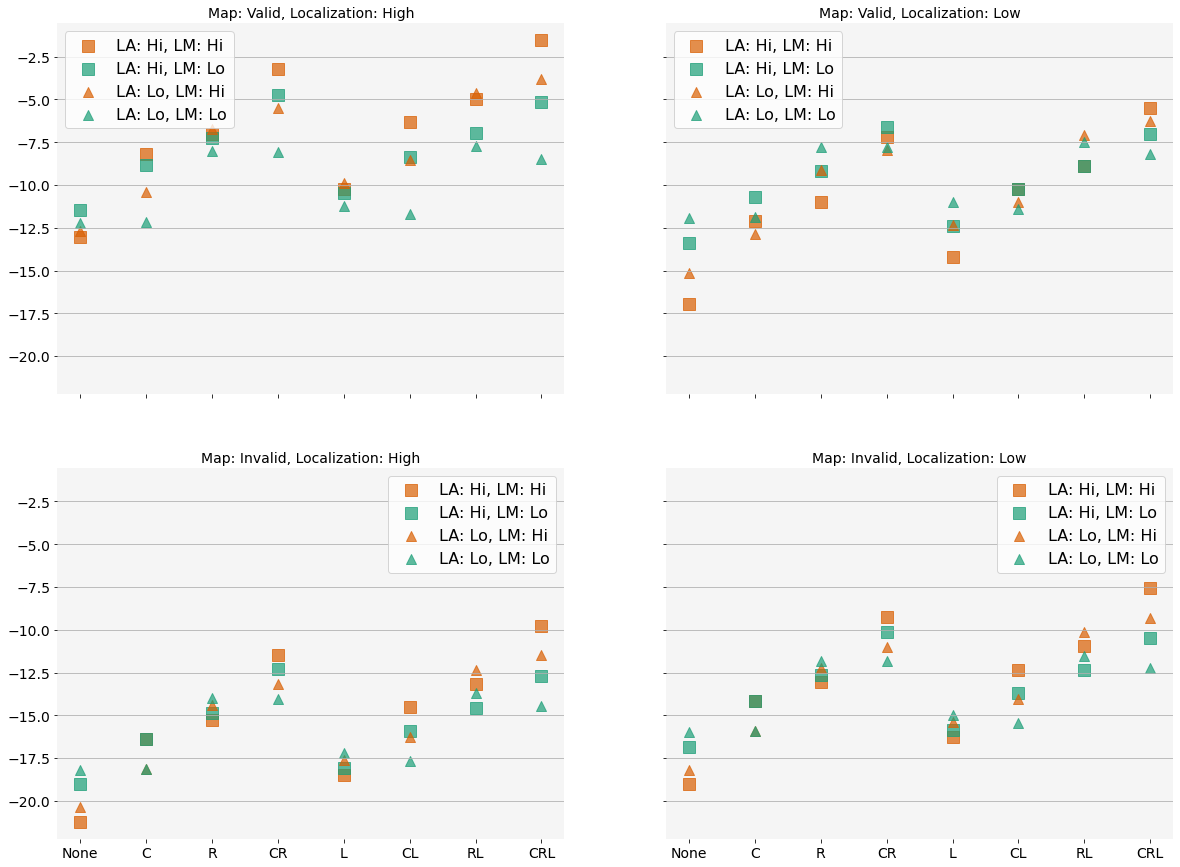

In [ ]:
make_plot(compute_probability_of_samples(model, 
                                         weather_label.cooperative, 
                                         lane_marking_match_symbol=match_label.detected,
                                         landmark_match_symbol=match_label.detected)
)

In this case the highest probability is that map is valid, localization is valid, and all sensors are in the nominal state. 

**Please note that the probability scale is logaritmic**


#### Cooperative weather, but no matches

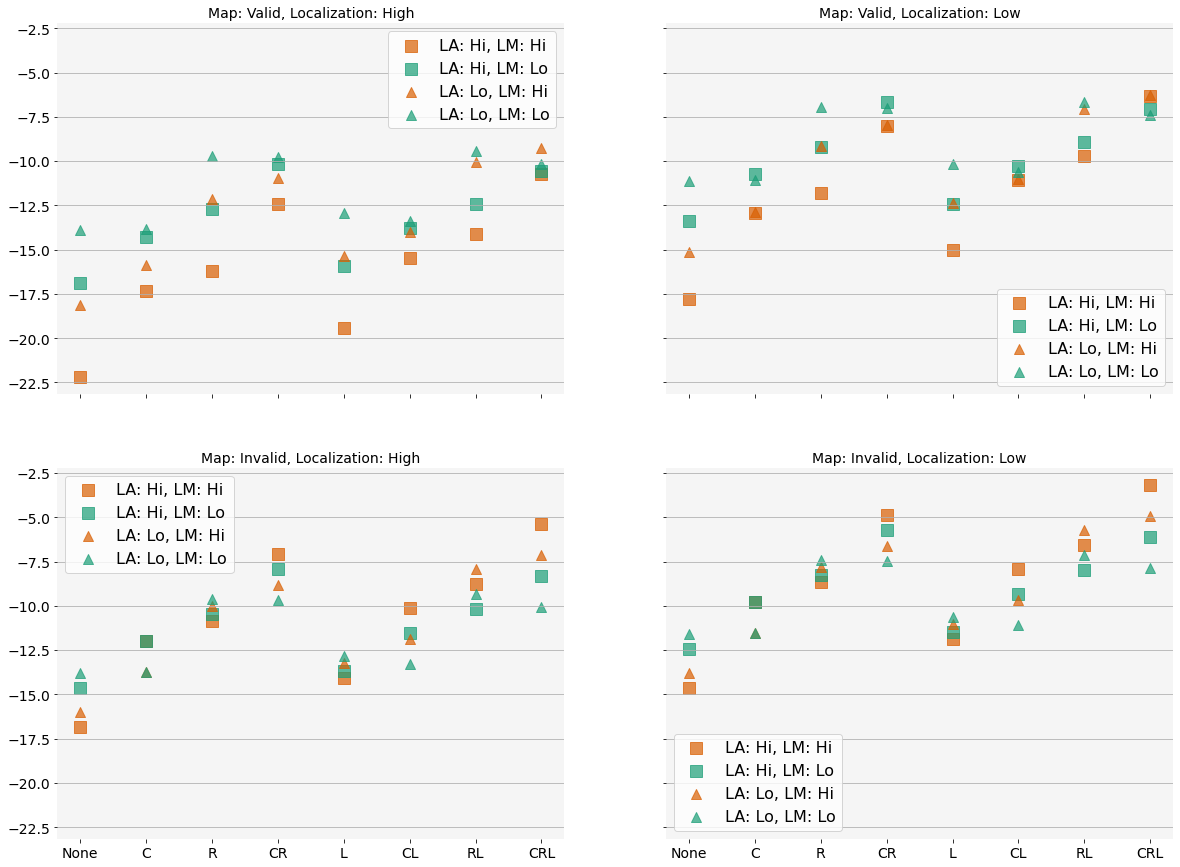

In [ ]:
make_plot(compute_probability_of_samples(model, 
                                         weather_label.cooperative, 
                                         lane_marking_match_symbol=match_label.not_detected,
                                         landmark_match_symbol=match_label.not_detected)
)

In this case, we see that the most likely case is that map is invalid and localization is also with low accuracy. 

This is interesting, since localization should be high due to the good status of the sensors. At the same time, if the map is invalid, localization cannot be high accuracy, or even valid. Hence the most likely event is that the map is invlaid **and** the localization is low accuracy

**NOTE** We may want to change the localization label from high and low, to valid and invalid.

#### Cooperative weather and one match only

###### Lane marking has a match, landmark no

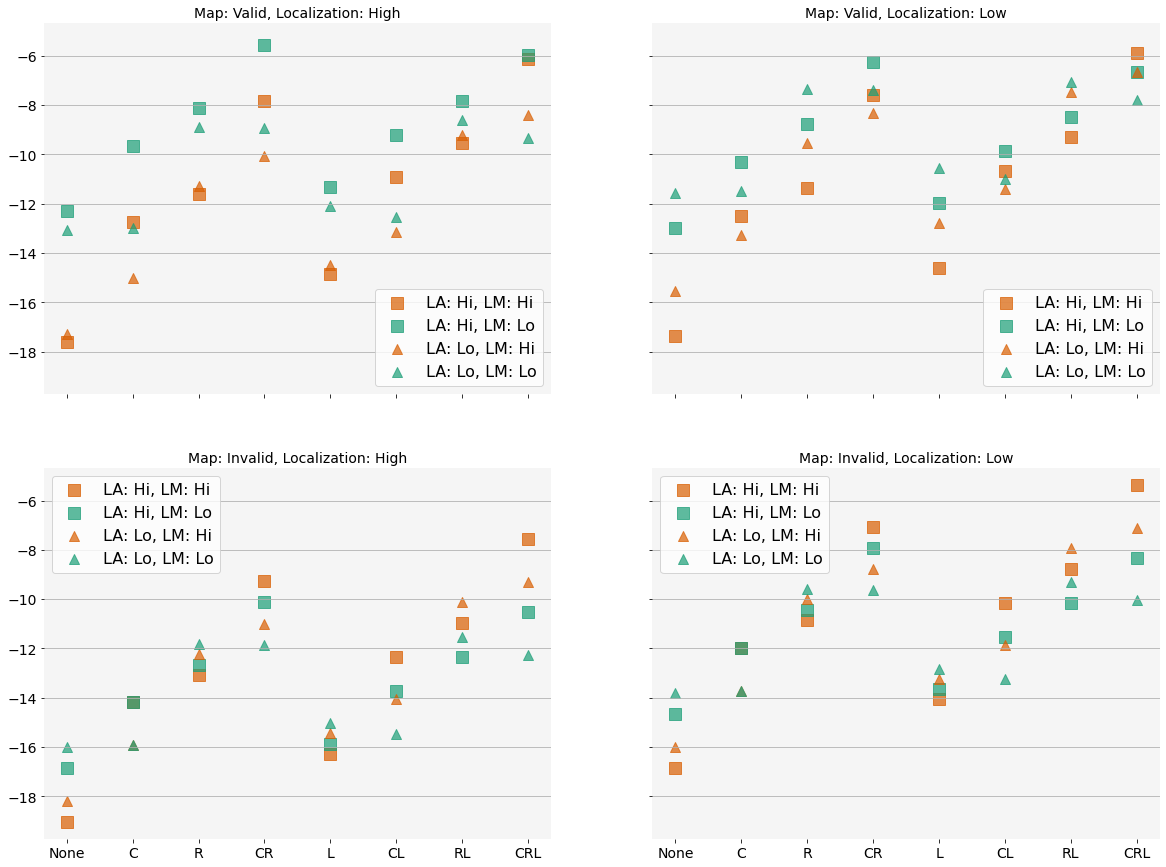

In [ ]:
make_plot(compute_probability_of_samples(model, 
                                         weather_label.cooperative, 
                                         lane_marking_match_symbol=match_label.detected,
                                         landmark_match_symbol=match_label.not_detected)
)

I am not completely sure of the correctness of this result. There is nothing clearly wrong with it, but it is complex and I would like to make sure that the outcome is reasonable.

###### Lane marking has no match, landmark yes

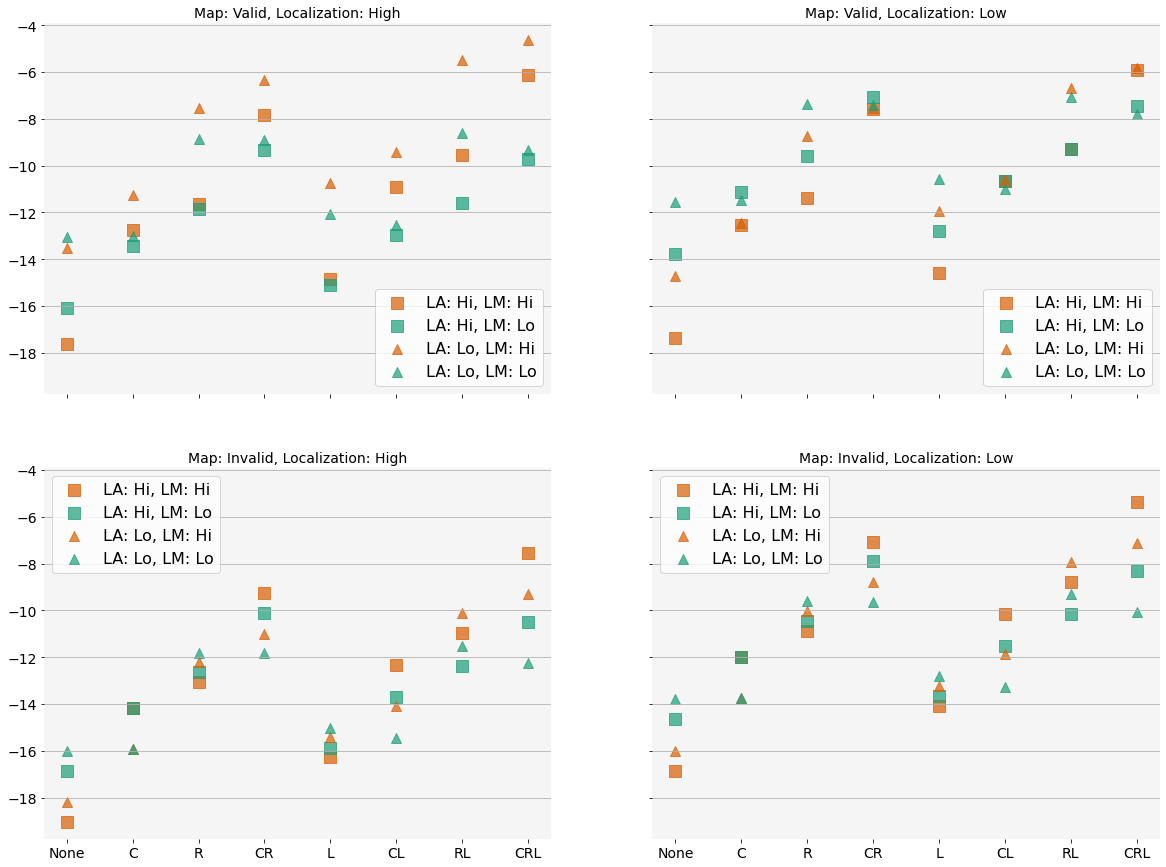

In [ ]:
make_plot(compute_probability_of_samples(model, 
                                         weather_label.cooperative, 
                                         lane_marking_match_symbol=match_label.not_detected,
                                         landmark_match_symbol=match_label.detected)
)

# Receving operating curve

The idea of this section is to perform an analysis of sensitivity of the model w.r.t. some parameters. It is currently unclear to me, what is the sensitivity we are looking for, but I guess that the ROC could be a good one.

The ROC is a curve on two dimensions, see https://de.wikipedia.org/wiki/ROC-Kurve

For computing the ROC curve we need to compute the probability of estimating a valid map, given that the map is valid (true positive rate) and the probability to compute a valid map, given that the map is invalid (false negative rate).

We can then change some parameters in the model and see what happens to the curve... so idea. Maybe it will even work ;)

In [ ]:
def find_probability_value_in_posterior(posteriors, variable_name, label):
  for i_posterior in posteriors:
    if i_posterior["name"] == variable_name:
      return i_posterior["distribution"][label]

  raise RuntimeError("Unable to find given variable_name. Name={}".format(variable_name))

# Returns the first key, value pair of a dictionary
def get_head_of_dictionary(in_dict):
  first_pair = list(in_dict.items())[0]
  out={}
  out[first_pair[0]] = first_pair[1]
  return out

# Returns the first key, value pair of a dictionary
def get_tail_of_dictionary(in_dict):
  key_value_pairs=list(in_dict.items())[1:]
  out = {}
  for i_pair in key_value_pairs:
    out[i_pair[0]] = i_pair[1]
  return out


def compute_conditional_of_symbols(model, symbols_to_compute_a_posteriori, symbols_to_which_to_condition_over):
  # we compute here the following probability
  # P(a_1, a_2, a_3| b_1,b_2,b_3) = P(a_1|a_2,a_3,b_1,b_2,b_3)*P(a_2|a_3,b_1,b_2,b_3)*P(a_3|a_3,b_1,b_2,b_3)
  # This is necessary, since pomegranate can compute the posterior of 1 variable, but not of a group of variables

  if len(symbols_to_compute_a_posteriori) == 1:
    posterior = compute_a_posteriori_from_symbols(model, symbols_to_which_to_condition_over)
    variable_name = list(symbols_to_compute_a_posteriori.keys())[0]
    variable_value = list(symbols_to_compute_a_posteriori.values())[0]
    probability_value = find_probability_value_in_posterior(posterior["posterior"], variable_name, variable_value)
  else:
    head_of_symbols_to_compute_a_posteriori = get_head_of_dictionary(symbols_to_compute_a_posteriori)
    tail_of_symbols_to_compute_a_posteriori = get_tail_of_dictionary(symbols_to_compute_a_posteriori)
    
    new_conditional = symbols_to_which_to_condition_over.copy()
    new_conditional.update(tail_of_symbols_to_compute_a_posteriori)
    probability_value = compute_conditional_of_symbols(model, head_of_symbols_to_compute_a_posteriori, new_conditional) * compute_conditional_of_symbols(model, tail_of_symbols_to_compute_a_posteriori, symbols_to_which_to_condition_over)

  return probability_value



In [ ]:
def get_all_evidence_values_that_lead_to_an_estimated_valid_map(model, probability_valid_map_threshold):
  evidence_values_that_lead_to_an_estimated_valid_map = []
  for weather_measurement in weather_label:
    for lane_marking_match_measurement in lane_marking_match_label:
      for landmark_match_measurement in landmark_match_label:
        conditioning_symbols = {weather.label: weather_measurement, landmark_match.label: landmark_match_measurement, lane_marking_match.label: lane_marking_match_measurement}
        probability_to_find = {map.label: map_labels.valid}
        probability_valid_map = compute_conditional_of_symbols(model, probability_to_find, conditioning_symbols)
        if probability_valid_map >= probability_valid_map_threshold:
          # this conditioning_symbols needs to be in output
          evidence_values_that_lead_to_an_estimated_valid_map.append(conditioning_symbols)
  return evidence_values_that_lead_to_an_estimated_valid_map


In [ ]:
def compute_true_positive(model, probability_valid_map_threshold):
  symbols_for_which_probability_need_to_be_computed = get_all_evidence_values_that_lead_to_an_estimated_valid_map(model, probability_valid_map_threshold)
  true_positive = 0.0
  for i_symbol in symbols_for_which_probability_need_to_be_computed:
    probability_of_i_symbol = compute_conditional_of_symbols(model, i_symbol, {map.label: map_labels.valid})
    true_positive += probability_of_i_symbol

  return true_positive

def compute_false_positive(model, probability_valid_map_threshold):
  symbols_for_which_probability_need_to_be_computed = get_all_evidence_values_that_lead_to_an_estimated_valid_map(model, probability_valid_map_threshold)
  false_positive = 0.0
  for i_symbol in symbols_for_which_probability_need_to_be_computed:
    probability_of_i_symbol = compute_conditional_of_symbols(model, i_symbol, {map.label: map_labels.invalid})
    false_positive += probability_of_i_symbol

  return false_positive

def compute_pair_true_positive_false_positive(model, probability_valid_map_threshold):
  true_positive = compute_true_positive(model, probability_valid_map_threshold)
  false_positive = compute_false_positive(model, probability_valid_map_threshold)

  return (true_positive, false_positive)

In [ ]:
compute_pair_true_positive_false_positive(model, 0.8)

(0.8469247524274434, 0.10000000000000021)

#### ROC curve as function of the map validity threshold probability

In [ ]:
n_threshold_values = 30
threshold = [value / (n_threshold_values) for value in range(n_threshold_values + 1)]
x = [0 for id in threshold]
y = [0 for id in threshold]

for idx in range(len(threshold)):
  current_pair = compute_pair_true_positive_false_positive(model, threshold[idx])
  x[idx] = current_pair[1]
  y[idx] = current_pair[0]


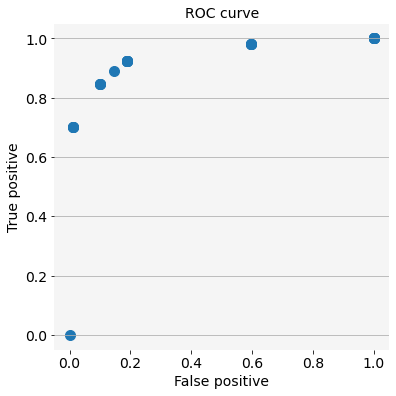

In [ ]:
fig, axs = plt.subplots(1, 1, frameon=False, figsize=(6,6))
axs.scatter(x, y, s = 100)
#axs.plot((0, 1), (0, 1), color="k", linewidth=0.5)
axs.set_title("ROC curve")
axs.set_xlabel("False positive")
axs.set_ylabel("True positive")
beautify_axes(axs)

X axes is the probability of false positive, i.e. we declare a map valid when it is not. The y axes is the probability of true positive, i.e. we declare a map valid when it is. 

This kind of plot must always lie over the 45 degree straight line connecting (0,0) to (1,1), otherwise the estimator makes no sense.

**This plot shows the estimator makes sense.**

We only have a few points, since the input variables takes discrete values and this set of values leads to a finite number of pairs of true positive, false positive values.

#### TPR and FPR as function of threshold

The plot below shows the TPR and FPR separately on two plots as function of the threshold used for claiming that a map is valid. Interesting, 0,4 looks like a better value than 0.5

**A note on better value**
Better value only means *a different compromise* between false positive and true positive. We are not improving the classifier here. We are only selecting the threshold value which leads to a point of the ROC curve which we claim as best compromise.

In order to improve the classifier, we need to tune the other parameters of the model. coming soon :)

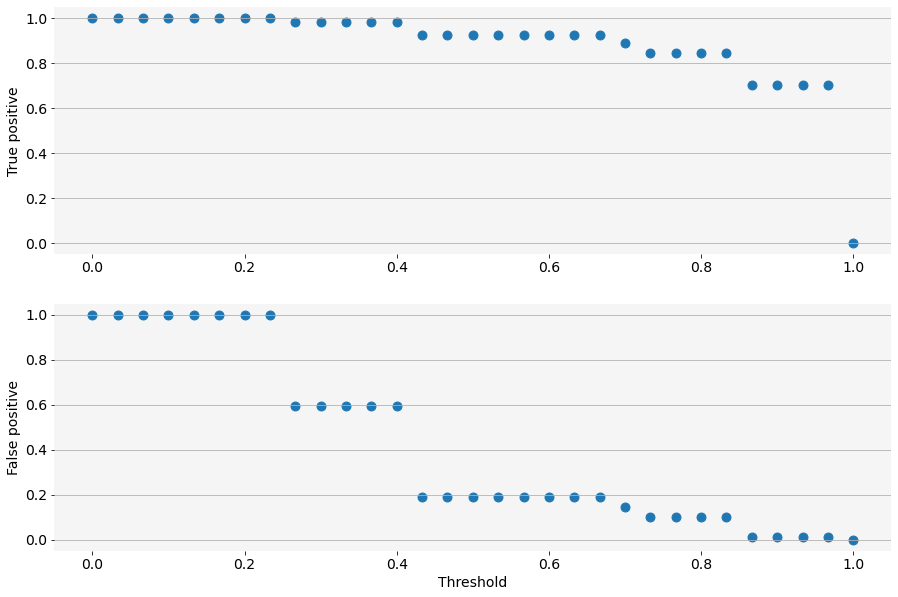

In [ ]:
fig, axs = plt.subplots(2, 1, frameon=False, figsize=(15,10))
axs[0].scatter(threshold, y, s=80)
axs[0].set_ylabel("True positive")

axs[1].scatter(threshold, x, s=80)
axs[1].set_ylabel("False positive")
axs[1].set_xlabel("Threshold")

beautify_axes(axs[0])
beautify_axes(axs[1])